# Preliminary operations

In [ ]:
#@title Drive mount

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Assignment/OriginalDataset

Mounted at /content/gdrive
/content/gdrive/MyDrive/Assignment/OriginalDataset


In [ ]:
#@title Main libraries
import pandas as pd
import numpy as np

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


# Get predictions effnet

In [ ]:
test_dir = '/content/gdrive/MyDrive/Assignment/Clean_And_Preprocessed_Dataset/CLEAN_and_HMP/TEST'

In [ ]:
data_hyperparameters = {
    'batch_size': 128,
    'resized_shape_height': 224, # as in chex net
    'resized_shape_width': 224,
    'color_mode': 'rgb' #'grayscale'
}

In [ ]:
test_set_effnet = ImageDataGenerator().flow_from_directory(directory = test_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

Found 3093 images belonging to 3 classes.


In [ ]:
effnetb0 = {  'name': 'EffNet_B0',
              'model': tfk.models.load_model("/content/gdrive/MyDrive/AI project/models/5.2. HMP_EffNet_model_30_01") }

In [ ]:
eff_predictions = effnetb0['model'].predict(test_set_effnet)

25/25 [==============================] - 194s 7s/step


In [ ]:
target = test_set_effnet.classes

Accuracy:  0.9663756870352409
F1 score:  [0.97317397 0.97549313 0.91176471]


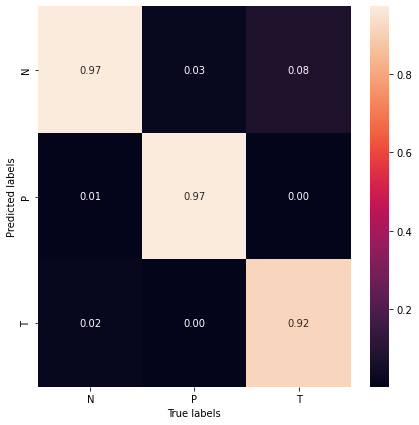

In [ ]:
pred= eff_predictions
print("Accuracy: ", accuracy_score(target, np.argmax(pred, axis=-1)))
print("F1 score: ", f1_score(target, np.argmax(pred, axis=-1), average=None))
cm = confusion_matrix(target, np.argmax(pred, axis=-1), normalize='true')
labels = ['N', 'P', 'T']
plt.figure(figsize=(7,7))
sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
data_hyperparameters = {
    'batch_size': 128,
    'resized_shape_height': 100,
    'resized_shape_width': 100,
    'color_mode': 'grayscale'
}

In [ ]:
test_set_resnet = ImageDataGenerator(rescale = 1/255.).flow_from_directory(directory = test_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

Found 3093 images belonging to 3 classes.


In [ ]:
resnet = {  'name': 'Resnet_SEblocks',
            'model': tfk.models.load_model("/content/gdrive/MyDrive/AI project/models/2.2. HMP_ResNet_model_01022023")} 

In [ ]:
resnet_predictions = resnet['model'].predict(test_set_resnet)

25/25 [==============================] - 334s 13s/step


In [ ]:
target = test_set_resnet.classes

Accuracy:  0.9553831231813773
F1 score:  [0.96386823 0.95985832 0.9010989 ]


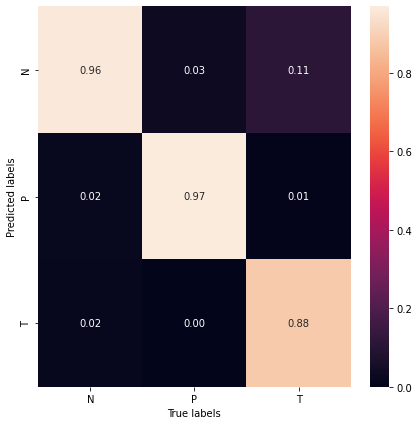

In [ ]:
pred= resnet_predictions
print("Accuracy: ", accuracy_score(target, np.argmax(pred, axis=-1)))
print("F1 score: ", f1_score(target, np.argmax(pred, axis=-1), average=None))
cm = confusion_matrix(target, np.argmax(pred, axis=-1), normalize='true')
labels = ['N', 'P', 'T']
plt.figure(figsize=(7,7))
sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
np.save('/content/gdrive/MyDrive/AI project/models/2.2. HMP_ResNet.npy', resnet_predictions) 

In [ ]:
np.save('/content/gdrive/MyDrive/AI project/models/5.2. HMP_EffNet.npy', eff_predictions) 

In [ ]:
test_set_resnet.classes == test_set_effnet.classes

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
np.save('/content/gdrive/MyDrive/AI project/models/target_ensemble', test_set_effnet.classes)

# Ensemble

In [ ]:
resnet = {  'name': 'Resnet_SEblocks',
            'predictions': np.load('/content/gdrive/MyDrive/AI project/models/2.2. HMP_ResNet.npy')}

effnetb0 = {  'name': 'EffNet_B0',
              'predictions': np.load('/content/gdrive/MyDrive/AI project/models/5.2. HMP_EffNet.npy')}
              
target = np.load('/content/gdrive/MyDrive/AI project/models/target_ensemble.npy')

In [ ]:
final_predictions = (resnet['predictions'] + effnetb0['predictions'])/2
final_predictions.shape

(3093, 3)

Accuracy:  0.9712253475590042
F1 score:  [0.97695364 0.97796307 0.92622951]


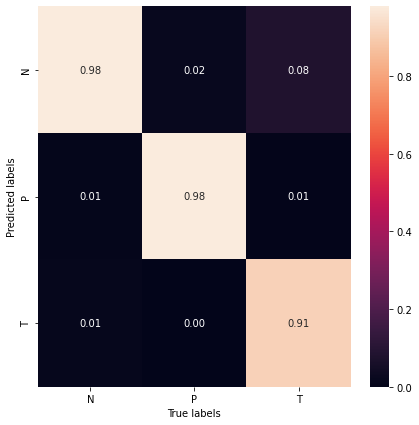

In [ ]:
pred= final_predictions
print("Accuracy: ", accuracy_score(target, np.argmax(pred, axis=-1)))
print("F1 score: ", f1_score(target, np.argmax(pred, axis=-1), average=None))
cm = confusion_matrix(target, np.argmax(pred, axis=-1), normalize='true')
labels = ['N', 'P', 'T']
plt.figure(figsize=(7,7))
sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels), yticklabels=list(labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
np.save('/content/gdrive/MyDrive/AI project/models/final_predictions_Ensemble.npy', final_predictions) 